In [1]:
%matplotlib inline
##########################################
# To use tensorflow follow instructions here: https://www.tensorflow.org/install/pip
# follow instructions related to creating a virtual environment with conda which can be the same 
# environment as ska3 here: https://github.com/sot/skare3/wiki/Ska3-runtime-environment-for-users
# ska is also needed
#########################################
import tensorflow as tf 
from tensorflow import keras
#from tensorflow.keras import layers
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sad_common_functions as cf

from Ska.engarchive import fetch
import Chandra.Time
from kadi import events

from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook, export_png
from bokeh.models import DatetimeTickFormatter
from bokeh.layouts import column, gridplot
output_notebook()

import sad_common_functions as cf
import timeit

Loading BokehJS ...

In [2]:
# adapted from "A Theoretically Grounded Application of Dropout in Recurrent Neural Networks"
# by Yarin Gal and Zoubin Ghahramani and corresponding github code
np.random.seed(0)
from keras.callbacks import Callback
from keras import backend as K
from keras import models, callbacks


from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.regularizers import l2
from keras.engine import training_arrays

# creating a custom callback by extending the base class "Callback:
# TODO: Might change custom function, we'll see
class ModelTest(Callback):
    ''' Test model at the end of every X epochs.
    The model is tested using both MC dropout and the dropout
    approximation. Output metrics for various losses are supported.
    # Arguments
        Xt: model inputs to test.
        Yt: model outputs to get accuracy / error (ground truth).
        T: number of samples to use in MC dropout.
        test_every_X_epochs: test every test_every_X_epochs epochs.
        batch_size: number of data points to put in each batch
            (often larger than training batch size).
        verbose: verbosity mode, 0 or 1.
        loss: a string from ['binary', 'categorical', 'euclidean']
            used to calculate the testing metric.
        mean_y_train: mean of outputs in regression cases to add back
            to model output ('euclidean' loss).
        std_y_train: std of outputs in regression cases to add back
            to model output ('euclidean' loss).
    # References
        - [Dropout: A simple way to prevent neural networks from overfitting](http://jmlr.org/papers/v15/srivastava14a.html)
        - [Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](http://arxiv.org/abs/1506.02142)
    '''
    def __init__(self, Xt, Yt, T=10, test_every_X_epochs=1, batch_size=500, verbose=1,
                 loss=None, mean_y_train=None, std_y_train=None):
        super(ModelTest, self).__init__()
        self.Xt = Xt
        self.Yt = np.array(Yt)
        self.T = T
        self.test_every_X_epochs = test_every_X_epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.loss = loss
        self.mean_y_train = mean_y_train
        self.std_y_train = std_y_train
        self._predict_stochastic = None
        
    def predict_stochastic(self, X, batch_size=128, verbose=0):
        '''Generate output predictions for the input samples
        batch by batch, using stochastic forward passes. If
        dropout is used at training, during prediction network
        units will be dropped at random as well. This procedure
        can be used for MC dropout (see [ModelTest callbacks](callbacks.md)).
        # Arguments
            X: the input data, as a numpy array.
            batch_size: integer.
            verbose: verbosity mode, 0 or 1.
        # Returns
            A numpy array of predictions.
        # References
            - [Dropout: A simple way to prevent neural networks from overfitting](http://jmlr.org/papers/v15/srivastava14a.html)
            - [Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](http://arxiv.org/abs/1506.02142)
        '''
        #X = models.standardize_X(X)
        #[model.layers[0].input, K.learning_phase()],
        #       [model.layers[-1].output]
        if self._predict_stochastic is None: # we only get self.model after init
            print (self.model.predict_function)
            self._predict_stochastic = K.function([self.model.inputs[0], K.learning_phase()], [self.model.outputs[0]])
        self.model.predict_function = self._predict_stochastic
        predictions = self.model.predict(X, batch_size, verbose)
        return predictions

    #i am 80% sure this equation gets called automagically 
    def on_epoch_begin(self, epoch, logs={}):
        if epoch % self.test_every_X_epochs != 0:
            return
        model_output = self.model.predict(self.Xt, batch_size=self.batch_size,
                                          verbose=self.verbose)
        MC_model_output = []
        for _ in range(self.T):
            MC_model_output += [self.predict_stochastic(self.Xt,
                                                   batch_size=self.batch_size,
                                                   verbose=self.verbose)]
        MC_model_output = np.array(MC_model_output)
        MC_model_output_mean = np.mean(MC_model_output, 0)

        if self.loss == 'binary':
            standard_acc = np.mean(self.Yt == np.round(model_output.flatten()))
            MC_acc = np.mean(self.Yt == np.round(MC_model_output_mean.flatten()))
            print("Standard accuracy at epoch %05d: %0.5f" % (epoch, float(standard_acc)))
            print("MC accuracy at epoch %05d: %0.5f" % (epoch, float(MC_acc)))
        elif self.loss == 'categorical':
            standard_acc = np.mean(np.argmax(self.Yt, axis=-1) == np.argmax(model_output, axis=-1))
            MC_acc = np.mean(np.argmax(self.Yt, axis=-1) == np.argmax(MC_model_output_mean, axis=-1))
            print("Standard accuracy at epoch %05d: %0.5f" % (epoch, float(standard_acc)))
            print("MC accuracy at epoch %05d: %0.5f" % (epoch, float(MC_acc)))
        elif self.loss == 'euclidean':
            model_output = model_output * self.std_y_train + self.mean_y_train
            standard_err = np.mean((self.Yt - model_output)**2.0, 0)**0.5
            MC_model_output_mean = MC_model_output_mean * self.std_y_train + self.mean_y_train
            MC_err = np.mean((self.Yt - MC_model_output_mean)**2.0, 0)**0.5
            print("Standard error at epoch %05d: %0.5f" % (epoch, float(standard_err)))
            print("MC error at epoch %05d: %0.5f" % (epoch, float(MC_err)))
        else:
            raise Exception('No loss: ' + loss)


Using TensorFlow backend.


In [3]:
import numexpr as ne
def quatty(quarts):
    from Quaternion import Quat
    quat = Quat(quarts)
    return ([quat.roll, quat.yaw])


# This function takes the aoattqt data and the msid data as an MSIDset
# and returns the combined dataset
def get_all_data(msid_data, quat_data, pitch_data):
    t1998 = 883612730.816
    from mica.quaternion import normalize
    quat_vals = normalize(np.vstack([quat_data["{}{}".format('AOATTQT',i)].vals for i in [1,2,3,4]]).transpose())
    #quat_vals = pd.DataFrame(x)
    start_time = timeit.default_timer()
    quat_vect = np.apply_along_axis(quatty, 1, quat_vals)
    print ("got quat vals: ", timeit.default_timer() - start_time)
    quat_times = data['AOATTQT1'].times
    print (quat_times.shape)
    roll_v, yaw_v = quat_vect[:,0], quat_vect[:,1]
    roll_df = pd.DataFrame({'times': quat_times, 'vals': roll_v})
    yaw_df = pd.DataFrame({'times':quat_times, 'vals': yaw_v})
    msid_data_tme = msid_data.times
    msid_times = np.array(pd.to_datetime(ne.evaluate('msid_data_tme + t1998'), 
                                         unit = 's', box = False), dtype = 'datetime64[s]')
    combined_dict = {'msid_times': msid_times, 
                     'raw_times': msid_data_tme,
                    'msid_vals': msid_data.vals,
                    'pitch': cf.select_intervals(msid_data, pitch_data), 
                    'roll': cf.select_intervals(msid_data,roll_df),
                    'yaw': cf.select_intervals(msid_data, yaw_df)}
    return (combined_dict)

def get_avg_set(spacing_int, data, var):
    padding_int = spacing_int - (data[var].shape[0]%spacing_int)
    padding = np.empty(padding_int, dtype=np.float32)
    padded_vals = np.concatenate((data[var], padding), axis=0)
    avg_vals = np.mean(padded_vals.reshape(-1,spacing_int), axis=1)[:-1]
    return (avg_vals)

def clean_data(data, cols, pos):
    #cleaning that needs to occur for all sets(train, validation, test)
    #first take out any null values with a mask
    #return the time data and the msid data (the time data is for plotting)
    subset = data[cols]
    mask = [all(tup) for tup in zip(*[~np.isnan(subset['{}'.format(i)]) for i in pos])]
    masked = subset[mask]
    #seperate out the time data
    msid_times = masked['msid_times']
    raw_times = masked['raw_times']
    raw_set = masked.drop(['msid_times', 'raw_times'], axis = 1)
    return raw_set, raw_times, msid_times

In [4]:
###### STEP 1: PICK MSID ######
msid_value = 'OOBTHR39'
# ['OOBTHR41','AIRU1G2I','AIRU1G1I','AIRU2G1I','AIRU2G2I','OOBTHR08', 'OOBTHR39','OOBTHR41','OOBTHR06','OOBTHR08','OOBTHR09','OOBTHR18','OOBTHR19','OOBTHR25','OOBTHR26','OOBTHR40','OOBTHR51', '2CBLUAST','2CBHUAST', 'DP_PITCH']

###### STEP 2: SINGLE OR COMPARE MULTIPLE YEARS ######
train_years = [2014,2015,2016,2017,2018]
test_year = 2019

need_to_pull = []
import pickle , os
file_format = '{}_{}_msid_data.pkl'
test_msid_file = file_format.format(msid_value, test_year)

###### STEP 3: PULL + COLLATE DATA ######
# 'collate' means calculate and assign a pitch, roll, yaw value to each time period
# this is done using sad_common_functions can look there for more ingo
#########################################

#check if we already have the data for the test year
if os.path.isfile(test_msid_file):
    print('Test file already exists, will not pull')
else:
    need_to_pull += [test_year]

#check if we have data for all the training years
for t_year in train_years:
    train_file = file_format.format(msid_value, t_year)
    if not os.path.isfile(train_file):
        need_to_pull += year
print("Here are the years we will pull data for: ", need_to_pull)
print("WARNING: COLLATING ONE YEAR OF DATA TAKES AROUND 15 MINUTES")

#if we don't have data for training years we pull, collate and save it 
for pull_year in  need_to_pull:
    start = '{}:001:00:00:00'.format(pull_year)
    stop = '{}:366:24:60:60'.format(pull_year)
    print(start, stop)
    
    attitudes = ['AOATTQT1', 'AOATTQT2', 'AOATTQT3', 'AOATTQT4']
    data = fetch.MSIDset( [msid_value, 'DP_PITCH'] + attitudes, start, stop, filter_bad = True)
    
    combined_dict = get_all_data(data[msid_value], data, data['DP_PITCH'])
    save_file = file_format.format(msid_value, pull_year)
    f = open(save_file, "wb")
    pickle.dump(combined_dict, f)
    f.close()

Test file already exists, will not pull
Here are the years we will pull data for:  []


In [8]:
from sklearn.preprocessing import MinMaxScaler

def scale_training(train_set, raw_msid_val):
    # normalize data (to be between 0 and 1) and then reshape 
    scaler_full = MinMaxScaler()
    scaled = scaler_full.fit_transform(train_set)
    # creating a seperate scaling for msid_vals cause honestly it's ruining my life
    scaler_msid = MinMaxScaler()
    scaled_msid_val = scaler_msid.fit_transform(raw_msid_val)
    # scaled_df = pd.DataFrame(scaled, columns = raw.columns).iloc[::spacing_int,:]
    scaled_train = pd.DataFrame(scaled, columns = train_set.columns)
    print ("big df shape: ", scaled_train.shape)

    return (scaler_full, scaler_msid, scaled_train)

def get_averaged_data(scaled_data, time, spacing_int, variables):
    intrv_times = time[::spacing_int][:-1]
    print ("intv_times shape: ", intrv_times.shape)
    # TODO: change shaping data to take in list of names to go in a dict, create df and shape it 
    intervaled_dict = {}
    for key in variables:
        intervaled_dict[key] = get_avg_set(spacing_int, scaled_data, key)
    intervaled_obs = pd.DataFrame(intervaled_dict)
    return (intervaled_obs, intrv_times)

def split_shaped_data(shaped_data, time, percentage, offset):
    chunk = int(shaped_data.shape[0]*(1-percentage))
    left_chunk, left_time = shaped_data[:chunk], time[:chunk]
    right_chunk,  right_time = shaped_data[chunk:],  time[chunk+offset:]
    print("chunk_sizes: (left, time, right, time)", left_chunk.shape, left_time.shape, right_chunk.shape, right_time.shape)
    return (left_chunk, left_time, right_chunk, right_time)

def create_model(n_neurons, timesteps, data_dim, p_W, p_U, weight_decay, p_dense):
    model=Sequential()
    model.add(LSTM(n_neurons, input_shape = (timesteps, data_dim),
                   kernel_regularizer=l2(weight_decay), U_regularizer=l2(weight_decay),
                   bias_regularizer=l2(weight_decay), dropout=p_W, recurrent_dropout=p_U))
    model.add(Dropout(p_dense))
    model.add(Dense(1,  kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
    optimiser = 'adam'
    model.compile(loss='mean_squared_error', optimizer=optimiser, metrics = ['accuracy'])
    return model

def uncertainties(predictions, model, validate_X, validate_y, batch_size, scaler_msid):
    # Model uncertainty and misspecification
    nu_1_squared_scaled = np.var(predictions, 0)
    ############ STEP 2: INFERENCE ###########
    # inputs: data x* , encoder g(), prediction network h(), dropout probability p, number of iterations B
    pred_v = model.predict(validate_X, batch_size=batch_size, verbose=1)
    pred_v_scaled = scaler_msid.inverse_transform(pred_v)
    val_scaled = scaler_msid.inverse_transform([validate_y])
    # inherent noise
    nu_2_squared_scaled = np.mean((pred_v_scaled - np.atleast_2d(val_scaled).T)**2)
    print(nu_2_squared_scaled)
    # total prediction uncertainty 
    nu_scaled = np.squeeze(np.sqrt(nu_1_squared_scaled + nu_2_squared_scaled))
    return (nu_scaled)

def get_predictions(model, modeltest, checkpoint_path, test_X, test_y, B, scaler_msid, scaler_all, batch_size):
    '''
    Using uncertainty algorithm structure from Lingxue Zhu 2017
    Step one is MCdropout
    inputs: data x* , encoder g(), prediction network h(), dropout probability p, number of iterations B
    outputs: prediction y-hat(mc), uncertainty nu_1
    '''
    model.load_weights(checkpoint_path)
    predictions = np.array([modeltest.predict_stochastic(test_X, batch_size=batch_size, verbose=0)
                            for _ in range(B)])
    print("predictions shape ", predictions.shape)
    scaled_predictions = []
    for x in predictions:
        scl = scaler_msid.inverse_transform(x)
        scaled_predictions += [scl]
    scaled_predictions = np.array(scaled_predictions)
    print("scaled_predictions: ", scaled_predictions.shape)
    # Our final prediction is the mean of B times
    #scaled_y_hat = np.mean(scaled_predictions, 0)
    return (scaled_predictions)

def get_uncertainties(scaled_predictions, model, validate_X, validate_y, scaler_msid, batch_size):
    # MODEL UNCERTAINTY AND MISSPECIFICATION
    print(scaled_predictions.shape)
    nu_1_squared_scaled = np.var(scaled_predictions, 0)
    print ("mean, max, min of nu_1", np.mean(nu_1_squared_scaled), np.max(nu_1_squared_scaled), np.min(nu_1_squared_scaled))
    ############ STEP 2: INFERENCE ###########
    # inputs: data x* , encoder g(), prediction network h(), dropout probability p, number of iterations B
    pred_v = model.predict(validate_X, batch_size=batch_size, verbose=1)
    pred_v_scaled = scaler_msid.inverse_transform(pred_v)
    val_scaled = scaler_msid.inverse_transform([validate_y])
    # inherent noise
    nu_2_squared_scaled = np.mean((pred_v_scaled - np.atleast_2d(val_scaled).T)**2)
    # total prediction uncertainty 
    nu_scaled = np.squeeze(np.sqrt(nu_1_squared_scaled + nu_2_squared_scaled))
    print("min max of nu scaled: ", np.min(nu_scaled), np.max(nu_scaled))
    print("nu scaled", nu_scaled.shape)
    return (nu_scaled)

def unscale_set(scaler, X, y, n_features, timesteps, data_dim):
    p_var = n_features - 1
    reshaped = X.reshape((X.shape[0], timesteps*data_dim))
    y = np.atleast_2d(y).T
    conc = np.concatenate((y, reshaped[:, -p_var:]), axis = 1)
    data_unscaled = scaler.inverse_transform(conc)
    return data_unscaled

def get_errors(time, predictions, uncertainty, z_alpha_half):
    err_xs = []
    err_ys = []
    for x, y, yerr in zip(time, predictions, uncertainty):
        x = x.to_datetime64()
        err_xs.append((x, x))
        err_ys.append((y -(z_alpha_half*yerr), y + (z_alpha_half*yerr)))
    return (err_xs,err_ys)

def run_model(train_set, test_set, spacing_int,
              cols, pos, n_features, frames, 
              p_W, p_U, weight_decay, p_dense, batch_size,
              n_neurons, train_year, epochs=100, dropout_B=100, z_alpha_half=1.960,
              percentage=0.3, use_full = False):
    # first we clean our training set 
    train_clean_set , train_raw_time, train_time = clean_data(train_set, cols, pos)
    raw_msid_val = train_clean_set.drop(pos, axis = 1)
    # scale training data and return the "scalers"
    scaler_all, scaler_msid, scaled_train = scale_training(train_clean_set, raw_msid_val)
    # shape data using our common function 
    shaped_train, begin_int = cf.shaping_data(scaled_train, pos, frames)
    # take the shaped data and return an averaged version 
    variables = pos + ['msid_vals']
    averaged_obs, train_time_avg = get_averaged_data(scaled_train, train_time, spacing_int, variables)
    shaped_train_avg, begin_int_avg = cf.shaping_data(averaged_obs, pos, frames)
    #
    # split training data that has already been shaped into training and validation
    shaped_train_full, train_time_full, shaped_val_full, val_time_full = split_shaped_data(shaped_train, train_time, percentage, begin_int)
    shaped_train_avg, train_time_avg, shaped_val_avg, val_time_avg = split_shaped_data(shaped_train_avg, train_time_avg, percentage, begin_int_avg)
    print(shaped_train_avg.shape, train_time_avg.shape)
    #
    # scale and shape test data
    test_clean_set, test_raw_time, test_time = clean_data(test_set, cols, pos)
    scaled_test = scaler_all.transform(test_clean_set)
    scaled_test = pd.DataFrame(scaled_test, columns = test_clean_set.columns)
    shaped_test, begin_int_test = cf.shaping_data(scaled_test, pos, frames)
    test_time = test_time[begin_int_test:]
    #
    # take shaped test, train and validation data and return inputs/outputs
    train_X_full, train_y_full = cf.split_io(shaped_train_full, frames, n_features)
    train_X_avg, train_y_avg = cf.split_io(shaped_train_avg, frames, n_features)
    validate_X, validate_y = cf.split_io(shaped_val_full, frames, n_features)
    test_X, test_y = cf.split_io(shaped_test, frames, n_features)
    #
    if use_full:
        train_X, train_y = train_X_full, train_y_full
    else: 
        train_X, train_y = train_X_avg, train_y_avg
    #create model
    timesteps, data_dim = train_X.shape[1] , train_X.shape[2]
    model = create_model(n_neurons, timesteps, data_dim, p_W, p_U, weight_decay, p_dense)
    #
    #create callback that will allow us to predict using dropout
    mean_y_train, std_y_train = np.mean(train_y), np.std(train_y)
    modeltest = ModelTest(test_X[:batch_size], mean_y_train + std_y_train * np.atleast_2d(train_y[:batch_size]).T,
                          test_every_X_epochs=20, verbose=0, loss='euclidean',
                          mean_y_train=mean_y_train, std_y_train=std_y_train, batch_size = batch_size)
    # checkpoint path to save weights
    checkpoint_path = 'weights_best_{}_yr{}_pW_{}_pU_{}_pdense{}'.format(msid_value,train_year, p_W, p_U, p_dense)
    checkpointer = callbacks.ModelCheckpoint(filepath= checkpoint_path,
                                             verbose = 0, save_best_only = True,
                                             save_weights_only = True, mode = 'min')
    fit_time_begin = timeit.default_timer()
    history = model.fit(train_X, train_y,validation_data=(validate_X, validate_y),
                        batch_size=batch_size, epochs=epochs, callbacks=[ checkpointer,  modeltest], shuffle = False , verbose = 0)
    fit_time = timeit.default_timer() - fit_time_begin
    
    data_to_return = [(train_X_full, train_y_full),(validate_X, validate_y), (test_X, test_y)]
    data_to_r = []
    for data_set in data_to_return:
        data_to_r += [unscale_set(scaler_all, data_set[0], data_set[1], n_features, timesteps, data_dim)]
    #data_to_return = [unscale_set(scaler_all, data_set[0], data_set[1], n_features, timesteps, data_dim) for data_set in data_to_return]
    data_to_return = data_to_r
    pred_time_begin = timeit.default_timer()
    scaled_predictions = get_predictions(model, modeltest, checkpoint_path, test_X, test_y, dropout_B, scaler_msid, scaler_all, batch_size)
    pred_time = timeit.default_timer() - pred_time_begin
    
    unc_time_begin = timeit.default_timer()
    total_uncertainty = get_uncertainties(scaled_predictions, model, validate_X, validate_y, scaler_msid, batch_size)
    unc_time = timeit.default_timer() - unc_time_begin
    
    print ("year: ", train_year, "fit_time: ", fit_time, "pred_time: ", pred_time, "unc_time: ", unc_time)
    
    predictions = np.mean(scaled_predictions,0)
    print ('predictions: ', predictions.shape)
    errors = total_uncertainty*z_alpha_half#errors = get_errors(test_time, predictions, total_uncertainty, z_alpha_half)
    prediction_data = [predictions, total_uncertainty, errors]
    full_time = [train_time_full, val_time_full, test_time]
    avg_time = [train_time_avg, val_time_avg, test_time]
    return (model, data_to_return, prediction_data, scaler_all, scaler_msid, full_time, avg_time, history, checkpoint_path, modeltest)

In [9]:
import math 
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

def plot_dashboard(plot_time, y_preds, y_actual, uncertainty, test_year, train_year, msid_value):
    err_top, err_bot = y_preds-uncertainty , y_preds+uncertainty

    fig = plt.figure(figsize=(22.5, 15), constrained_layout=True)
    gs = fig.add_gridspec(6,3)

    ax1 = fig.add_subplot(gs[0:4,:-1])
    ##########################
    # Plotting Predicted vs Actual
    # x axis is time, y axis is msid
    ##########################
    ax1.plot(plot_time, y_preds, '.' , markersize = 1, label = 'predicted', color = 'tab:orange')
    ax1.plot(plot_time, y_actual, '.', markersize = 1, label = 'actual', color = 'black')
    ax1.fill_between(plot_time.values, err_top, err_bot, label = 'uncertainty', color = 'grey')
    ax1.legend(markerscale=12.0)
    ax1.set_xticklabels(plot_time, rotation=45)
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y:%j"))
    ax1.set_title('Predicted vs Actual {} {}'.format(msid_value, train_year))


    #########################
    # Plotting Model Error which is just actual y value minus test y value
    # x axis is time, y axis is error 
    #########################
    ax2 = fig.add_subplot(gs[4,:-1])
    errors =  y_actual - y_preds
    dist_top = err_top - y_actual
    dist_bot = err_bot - y_actual
    #one_perc = np.quantile(errors, 0.01)
    #nn_perc = np.quantile(errors, .99)
    scale = np.ptp(y_actual)/2.0
    ax2.plot(plot_time, errors, color = 'green')
    ax2.plot(plot_time, dist_top, color = 'gray')
    ax2.plot(plot_time, dist_bot, color = 'gray')
    ax2.set_ylim(-scale, scale)
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticklabels(plot_time, rotation=45)
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y:%j"))

    ax2.set_title('Model Error (Actual - Test) {} {}'.format(msid_value, train_year))

    #########################
    # Plotting Error by Temperature
    # 
    #########################
    ax3 = fig.add_subplot(gs[0:4,2])
    ax3.plot(errors, y_actual, '.', color = 'green')
    ax3.set_xlim(-scale, scale)
    ax3.set_ylim(ax1.get_ylim())
    ax3.set_title('Actual vs. Model Error {} {}'.format(msid_value, train_year))

    ax4 = fig.add_subplot(gs[4, 2])
    ax4.hist(errors, bins = 25, density=True, color= 'green')
    ax4.set_xlim(ax3.get_xlim())
    ax4.set_title("Error Distribution {} {}".format(msid_value, train_year))

    plt.savefig('{}_test{}_train{}_full_dash.png'.format(msid_value, test_year, train_year))
    plt.show()

dict_keys(['msid_times', 'raw_times', 'msid_vals', 'pitch', 'roll', 'yaw']) dict_keys(['msid_times', 'raw_times', 'msid_vals', 'pitch', 'roll', 'yaw'])


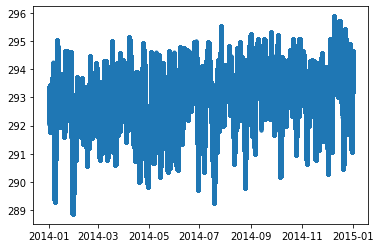

Enter a lower limit if needed:
Enter an upper limit if needed:
(961575, 6)


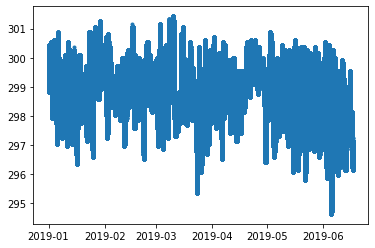

big df shape:  (961575, 3)
intv_times shape:  (32052,)
chunk_sizes: (left, time, right, time) (769253, 25) (769253,) (192314, 25) (192314,)
chunk_sizes: (left, time, right, time) (25635, 25) (25635,) (6409, 25) (6409,)
(25635, 25) (25635,)


/home/lduque/miniconda3/envs/ska3/lib/python3.6/site-packages/ipykernel/__main__.py:37: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(8, input_shape=(8, 3), kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., dropout=0.05, recurrent_dropout=0.05, recurrent_regularizer=<keras.reg...)`


Standard error at epoch 00000: 0.10018
MC error at epoch 00000: 0.10018
Standard error at epoch 00020: 0.12685
MC error at epoch 00020: 0.12685
Standard error at epoch 00040: 0.11312
MC error at epoch 00040: 0.11312
Standard error at epoch 00060: 0.10221
MC error at epoch 00060: 0.10221
Standard error at epoch 00080: 0.12801
MC error at epoch 00080: 0.12801
Standard error at epoch 00100: 0.15143
MC error at epoch 00100: 0.15143
Standard error at epoch 00120: 0.15432
MC error at epoch 00120: 0.15432
Standard error at epoch 00140: 0.14631
MC error at epoch 00140: 0.14631
predictions shape  (100, 440328, 1)
scaled_predictions:  (100, 440328, 1)
(100, 440328, 1)
mean, max, min of nu_1 6.101564e-08 1.8253922e-07 0.0
192314/192314 [==============================] - 1s 3us/step
min max of nu scaled:  0.21971683 0.21971725
nu scaled (440328,)
year:  2014 fit_time:  151.24125427706167 pred_time:  129.10005049360916 unc_time:  0.7681404030881822
predictions:  (440328, 1)


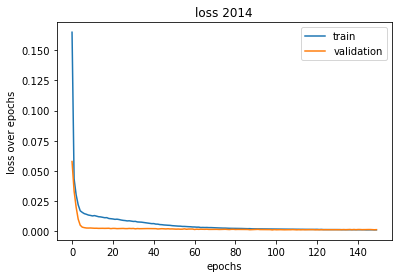

(769253, 3) (192314, 3) (440328, 3)
(769253,) (192314,) (440328,)
Test RMSE 2014: 0.699738408248604


/home/lduque/miniconda3/envs/ska3/lib/python3.6/site-packages/ipykernel/__main__.py:63: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


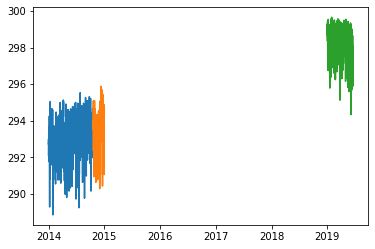

/home/lduque/miniconda3/envs/ska3/lib/python3.6/site-packages/IPython/core/pylabtools.py:121: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


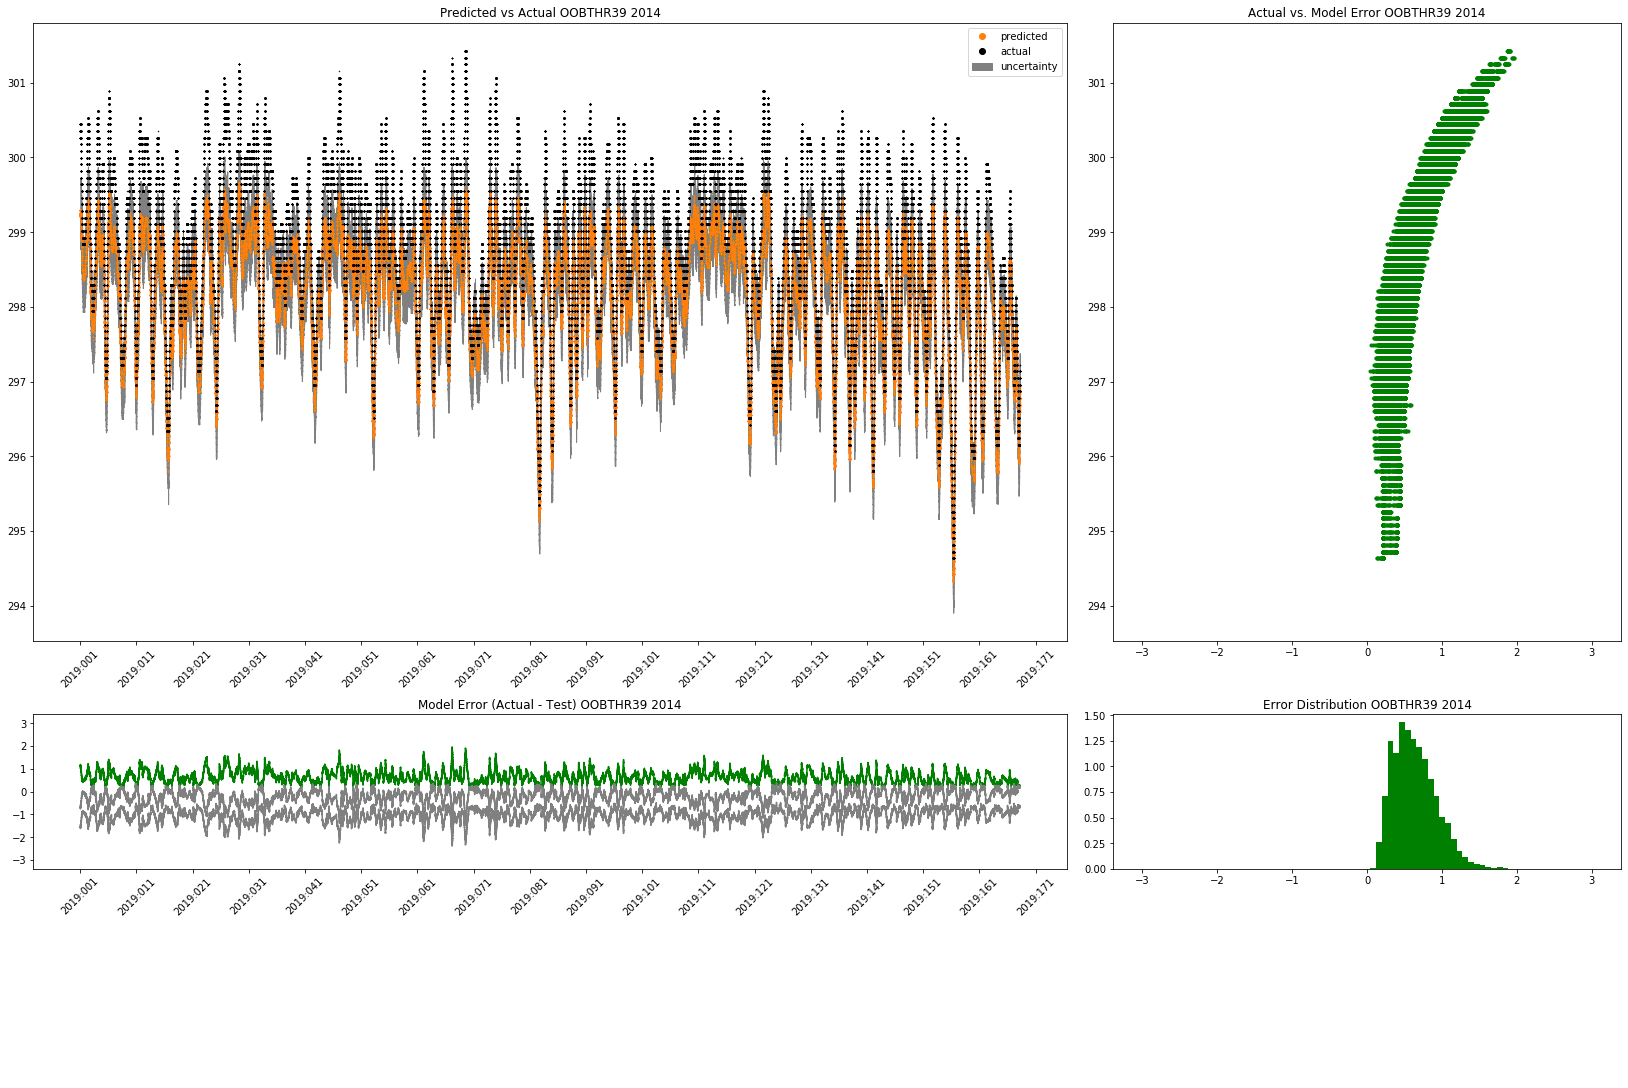

dict_keys(['msid_times', 'raw_times', 'msid_vals', 'pitch', 'roll', 'yaw']) dict_keys(['msid_times', 'raw_times', 'msid_vals', 'pitch', 'roll', 'yaw'])


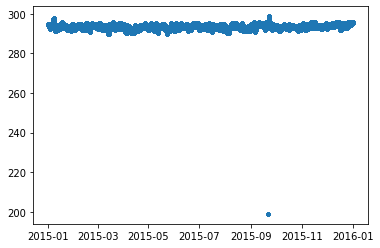

Enter a lower limit if needed:220
Enter an upper limit if needed:
(960538, 6)


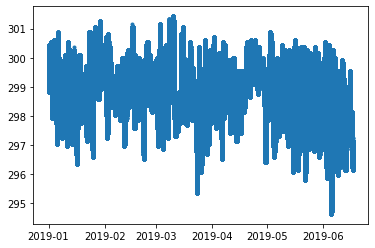

big df shape:  (960538, 3)
intv_times shape:  (32017,)
chunk_sizes: (left, time, right, time) (768424, 25) (768424,) (192106, 25) (192106,)
chunk_sizes: (left, time, right, time) (25607, 25) (25607,) (6402, 25) (6402,)
(25607, 25) (25607,)
Standard error at epoch 00000: 0.01854
MC error at epoch 00000: 0.01854
Standard error at epoch 00020: 0.09004
MC error at epoch 00020: 0.09004
Standard error at epoch 00040: 0.08345
MC error at epoch 00040: 0.08345
Standard error at epoch 00060: 0.08224
MC error at epoch 00060: 0.08224
Standard error at epoch 00080: 0.07990
MC error at epoch 00080: 0.07990
Standard error at epoch 00100: 0.07898
MC error at epoch 00100: 0.07898
Standard error at epoch 00120: 0.07927
MC error at epoch 00120: 0.07927
Standard error at epoch 00140: 0.07979
MC error at epoch 00140: 0.07979
predictions shape  (100, 440328, 1)
scaled_predictions:  (100, 440328, 1)
(100, 440328, 1)
mean, max, min of nu_1 6.1862686e-08 1.8253922e-07 0.0
192106/192106 [=======================

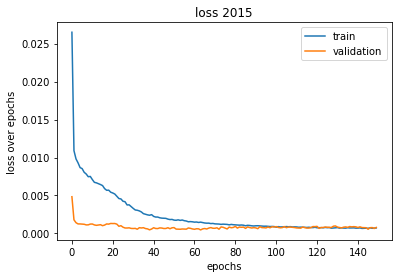

(768424, 3) (192106, 3) (440328, 3)
(768424,) (192106,) (440328,)
Test RMSE 2015: 0.7496331408254896


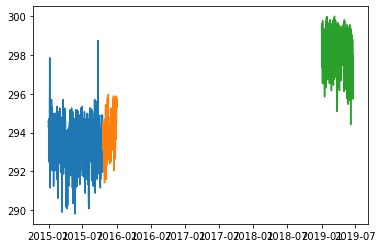

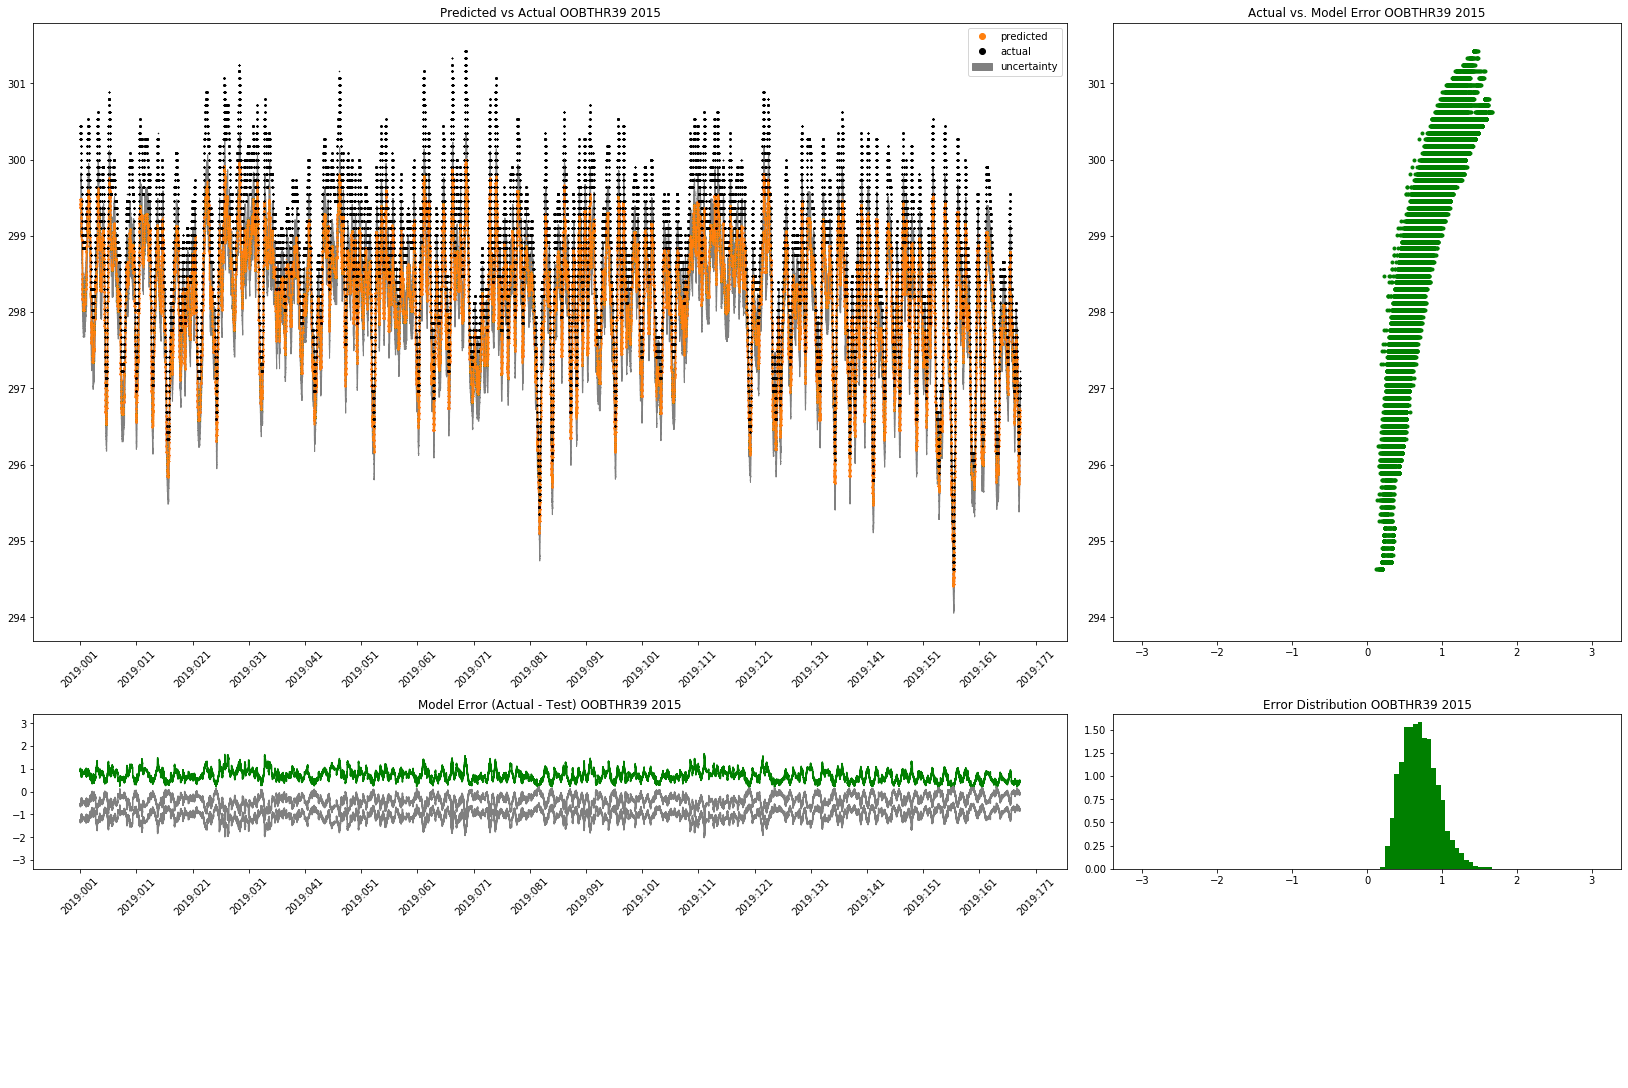

dict_keys(['msid_times', 'raw_times', 'msid_vals', 'pitch', 'roll', 'yaw']) dict_keys(['msid_times', 'raw_times', 'msid_vals', 'pitch', 'roll', 'yaw'])


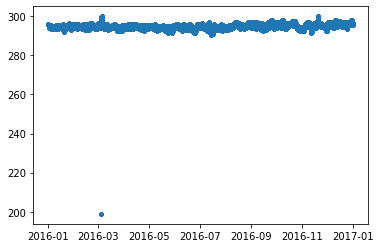

Enter a lower limit if needed:220
Enter an upper limit if needed:
(964149, 6)


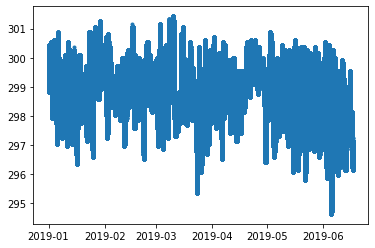

big df shape:  (964149, 3)
intv_times shape:  (32138,)
chunk_sizes: (left, time, right, time) (771312, 25) (771312,) (192829, 25) (192829,)
chunk_sizes: (left, time, right, time) (25704, 25) (25704,) (6426, 25) (6426,)
(25704, 25) (25704,)
Standard error at epoch 00000: 0.12714
MC error at epoch 00000: 0.12714
Standard error at epoch 00020: 0.01505
MC error at epoch 00020: 0.01505
Standard error at epoch 00040: 0.03574
MC error at epoch 00040: 0.03574
Standard error at epoch 00060: 0.04468
MC error at epoch 00060: 0.04468
Standard error at epoch 00080: 0.05306
MC error at epoch 00080: 0.05306
Standard error at epoch 00100: 0.06872
MC error at epoch 00100: 0.06872
Standard error at epoch 00120: 0.06719
MC error at epoch 00120: 0.06719
Standard error at epoch 00140: 0.06469
MC error at epoch 00140: 0.06469
predictions shape  (100, 440328, 1)
scaled_predictions:  (100, 440328, 1)
(100, 440328, 1)
mean, max, min of nu_1 6.194918e-08 1.8253922e-07 0.0
192829/192829 [========================

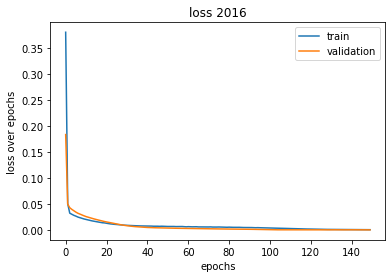

(771312, 3) (192829, 3) (440328, 3)
(771312,) (192829,) (440328,)
Test RMSE 2016: 0.3251477617353099


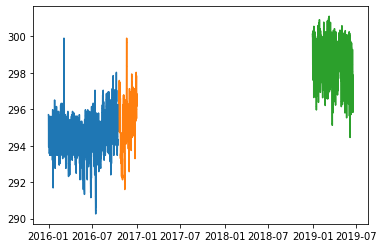

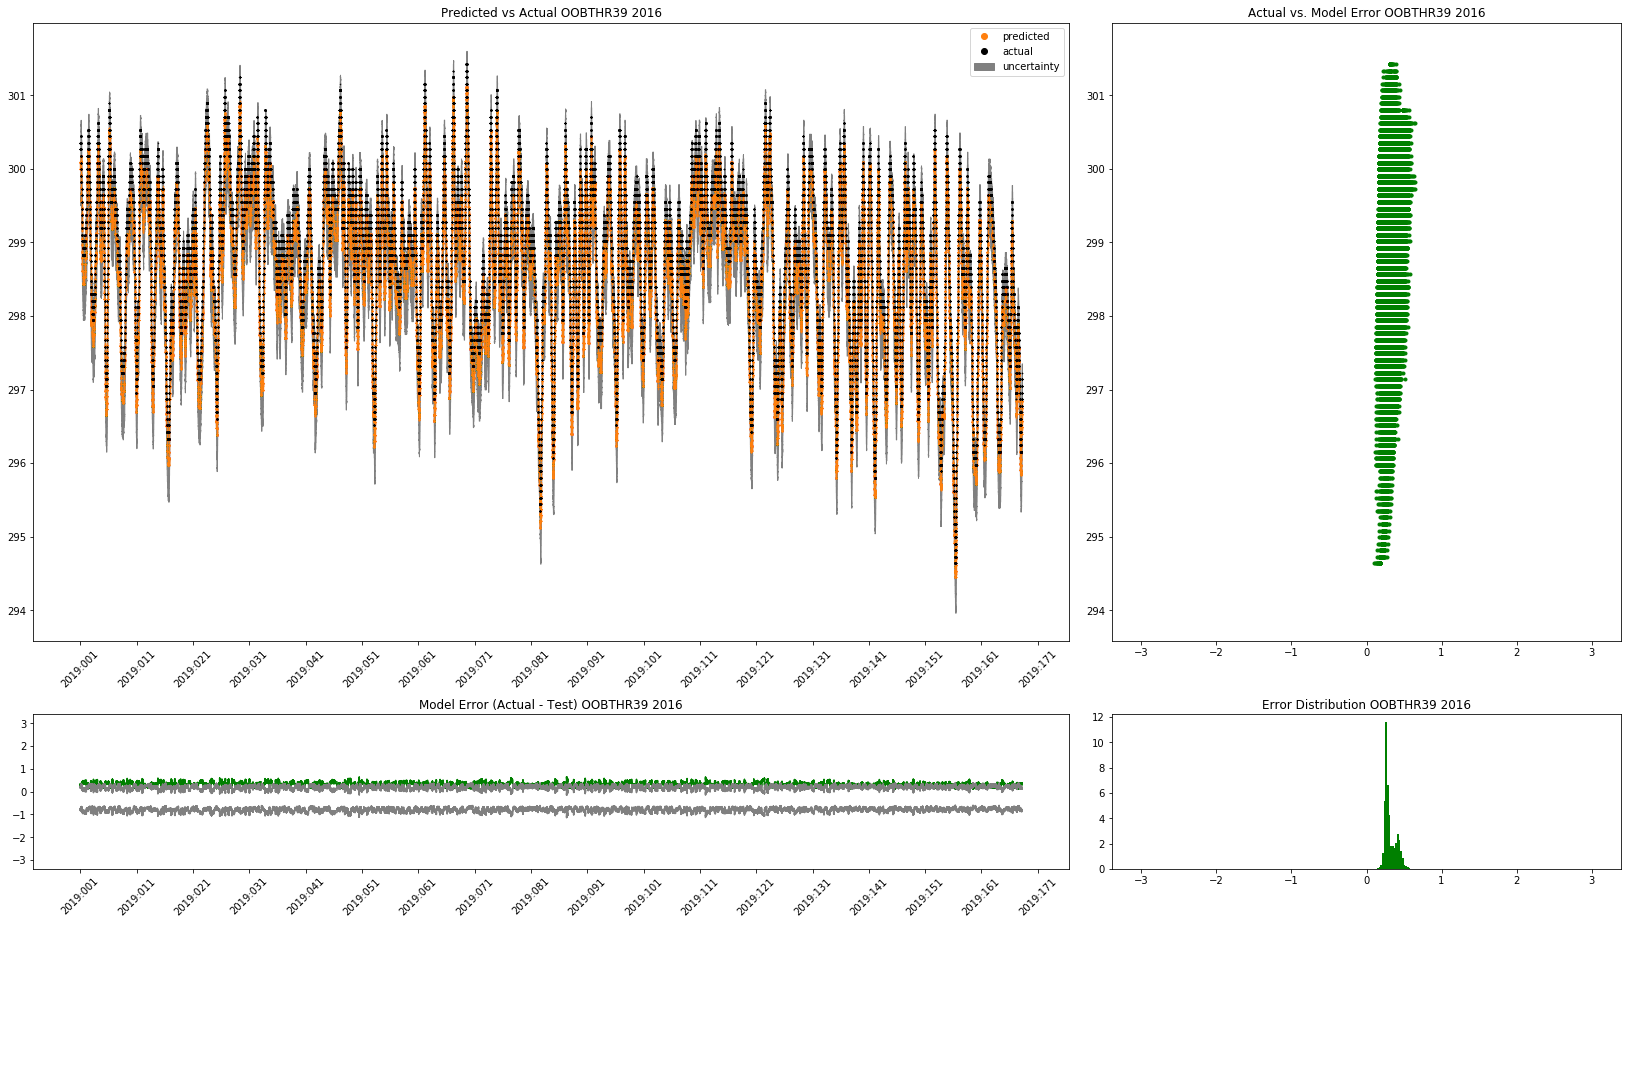

dict_keys(['msid_times', 'raw_times', 'msid_vals', 'pitch', 'roll', 'yaw']) dict_keys(['msid_times', 'raw_times', 'msid_vals', 'pitch', 'roll', 'yaw'])


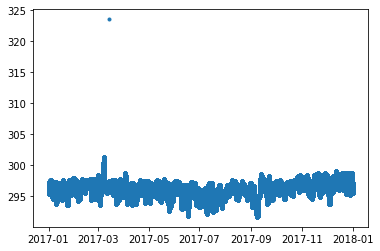

Enter a lower limit if needed:
Enter an upper limit if needed:320
(961573, 6)


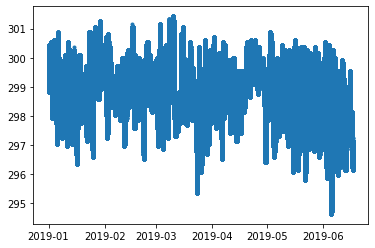

big df shape:  (961573, 3)
intv_times shape:  (32052,)
chunk_sizes: (left, time, right, time) (769252, 25) (769252,) (192313, 25) (192313,)
chunk_sizes: (left, time, right, time) (25635, 25) (25635,) (6409, 25) (6409,)
(25635, 25) (25635,)
Standard error at epoch 00000: 0.05483
MC error at epoch 00000: 0.05483
Standard error at epoch 00020: 0.02533
MC error at epoch 00020: 0.02533
Standard error at epoch 00040: 0.03434
MC error at epoch 00040: 0.03434
Standard error at epoch 00060: 0.04610
MC error at epoch 00060: 0.04610
Standard error at epoch 00080: 0.05009
MC error at epoch 00080: 0.05009
Standard error at epoch 00100: 0.04388
MC error at epoch 00100: 0.04388
Standard error at epoch 00120: 0.04491
MC error at epoch 00120: 0.04491
Standard error at epoch 00140: 0.04608
MC error at epoch 00140: 0.04608
predictions shape  (100, 440328, 1)
scaled_predictions:  (100, 440328, 1)
(100, 440328, 1)
mean, max, min of nu_1 6.258221e-08 1.8253922e-07 0.0
192313/192313 [========================

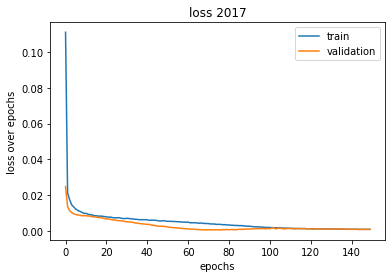

(769252, 3) (192313, 3) (440328, 3)
(769252,) (192313,) (440328,)
Test RMSE 2017: 0.46332149041605375


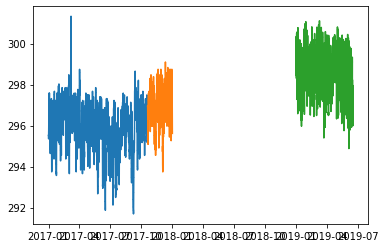

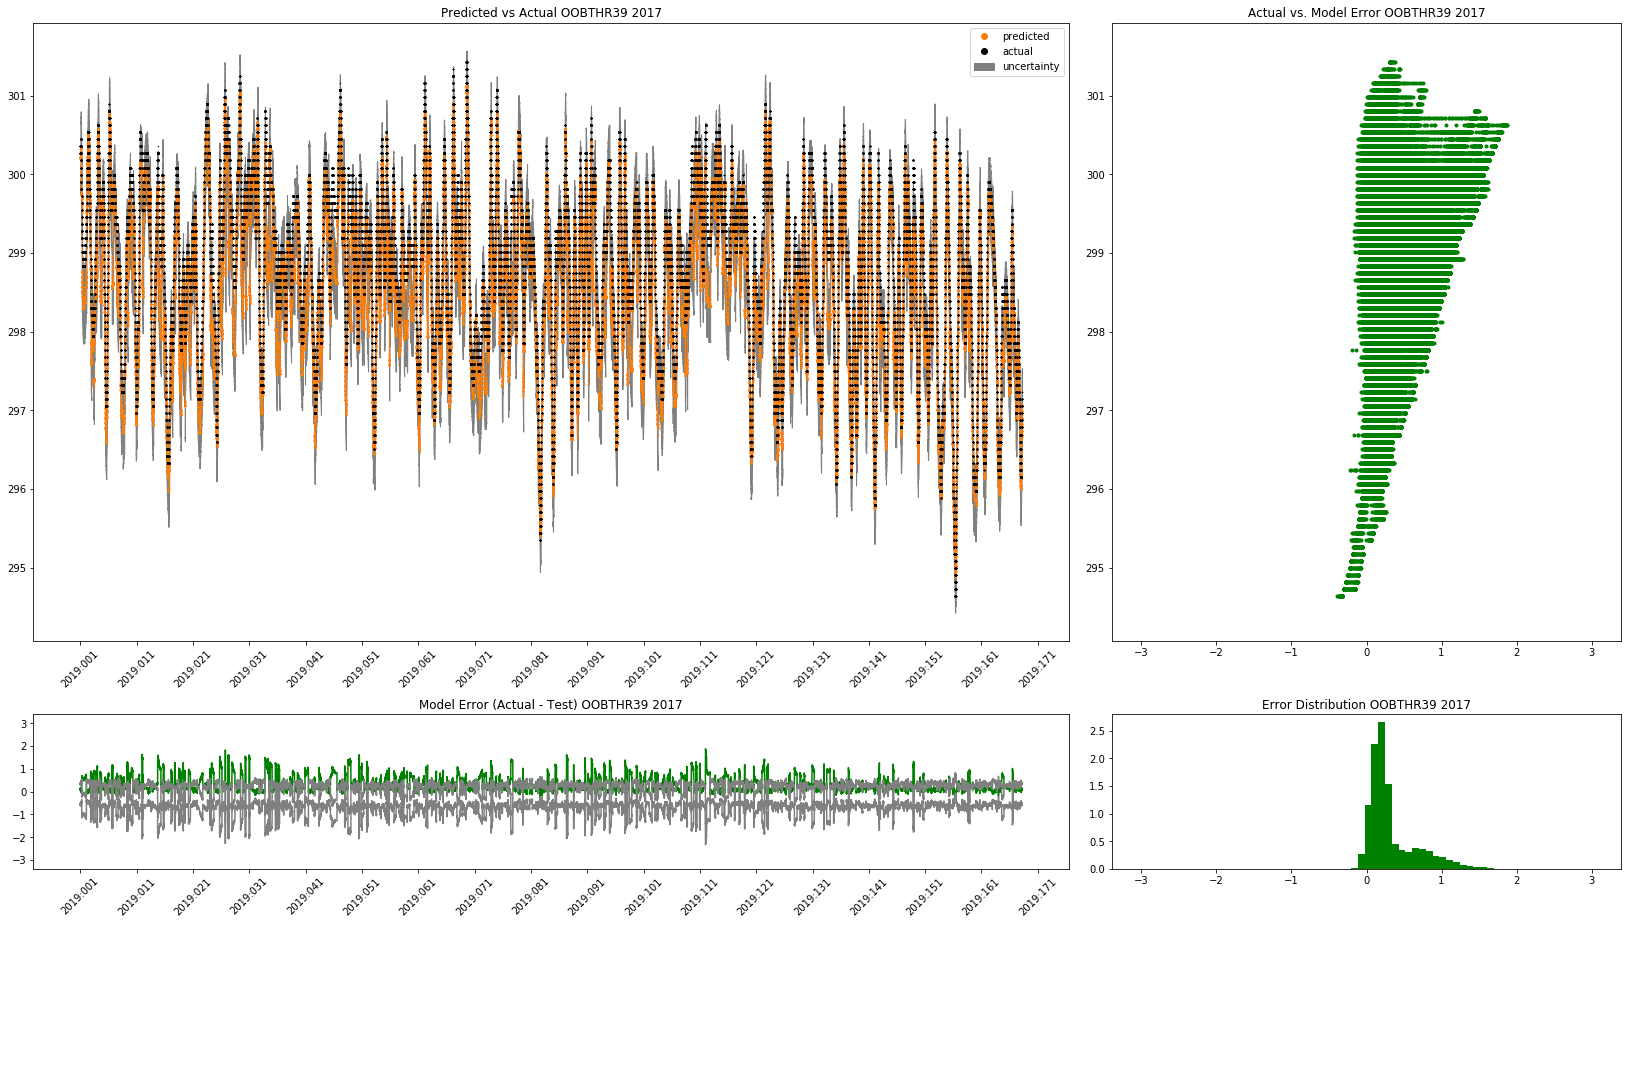

dict_keys(['msid_times', 'raw_times', 'msid_vals', 'pitch', 'roll', 'yaw']) dict_keys(['msid_times', 'raw_times', 'msid_vals', 'pitch', 'roll', 'yaw'])


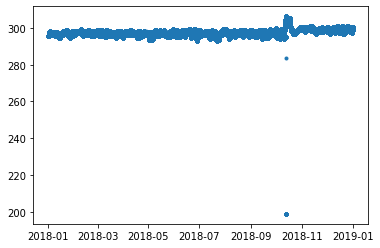

Enter a lower limit if needed:285
Enter an upper limit if needed:
(961519, 6)


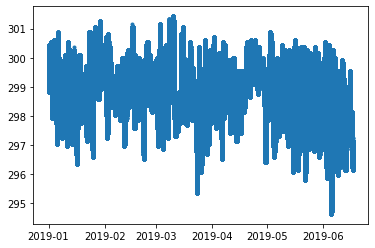

big df shape:  (961519, 3)
intv_times shape:  (32050,)
chunk_sizes: (left, time, right, time) (769208, 25) (769208,) (192303, 25) (192303,)
chunk_sizes: (left, time, right, time) (25633, 25) (25633,) (6409, 25) (6409,)
(25633, 25) (25633,)
Standard error at epoch 00000: 0.00465
MC error at epoch 00000: 0.00465
Standard error at epoch 00020: 0.01905
MC error at epoch 00020: 0.01905
Standard error at epoch 00040: 0.01973
MC error at epoch 00040: 0.01973
Standard error at epoch 00060: 0.02374
MC error at epoch 00060: 0.02374
Standard error at epoch 00080: 0.02464
MC error at epoch 00080: 0.02464
Standard error at epoch 00100: 0.02433
MC error at epoch 00100: 0.02433
Standard error at epoch 00120: 0.02306
MC error at epoch 00120: 0.02306
Standard error at epoch 00140: 0.02394
MC error at epoch 00140: 0.02394
predictions shape  (100, 440328, 1)
scaled_predictions:  (100, 440328, 1)
(100, 440328, 1)
mean, max, min of nu_1 6.2386725e-08 1.8253922e-07 0.0
192303/192303 [=======================

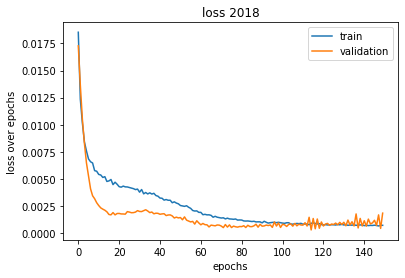

(769208, 3) (192303, 3) (440328, 3)
(769208,) (192303,) (440328,)
Test RMSE 2018: 0.1705806214399645


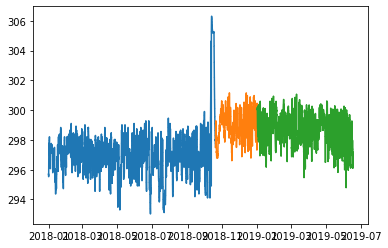

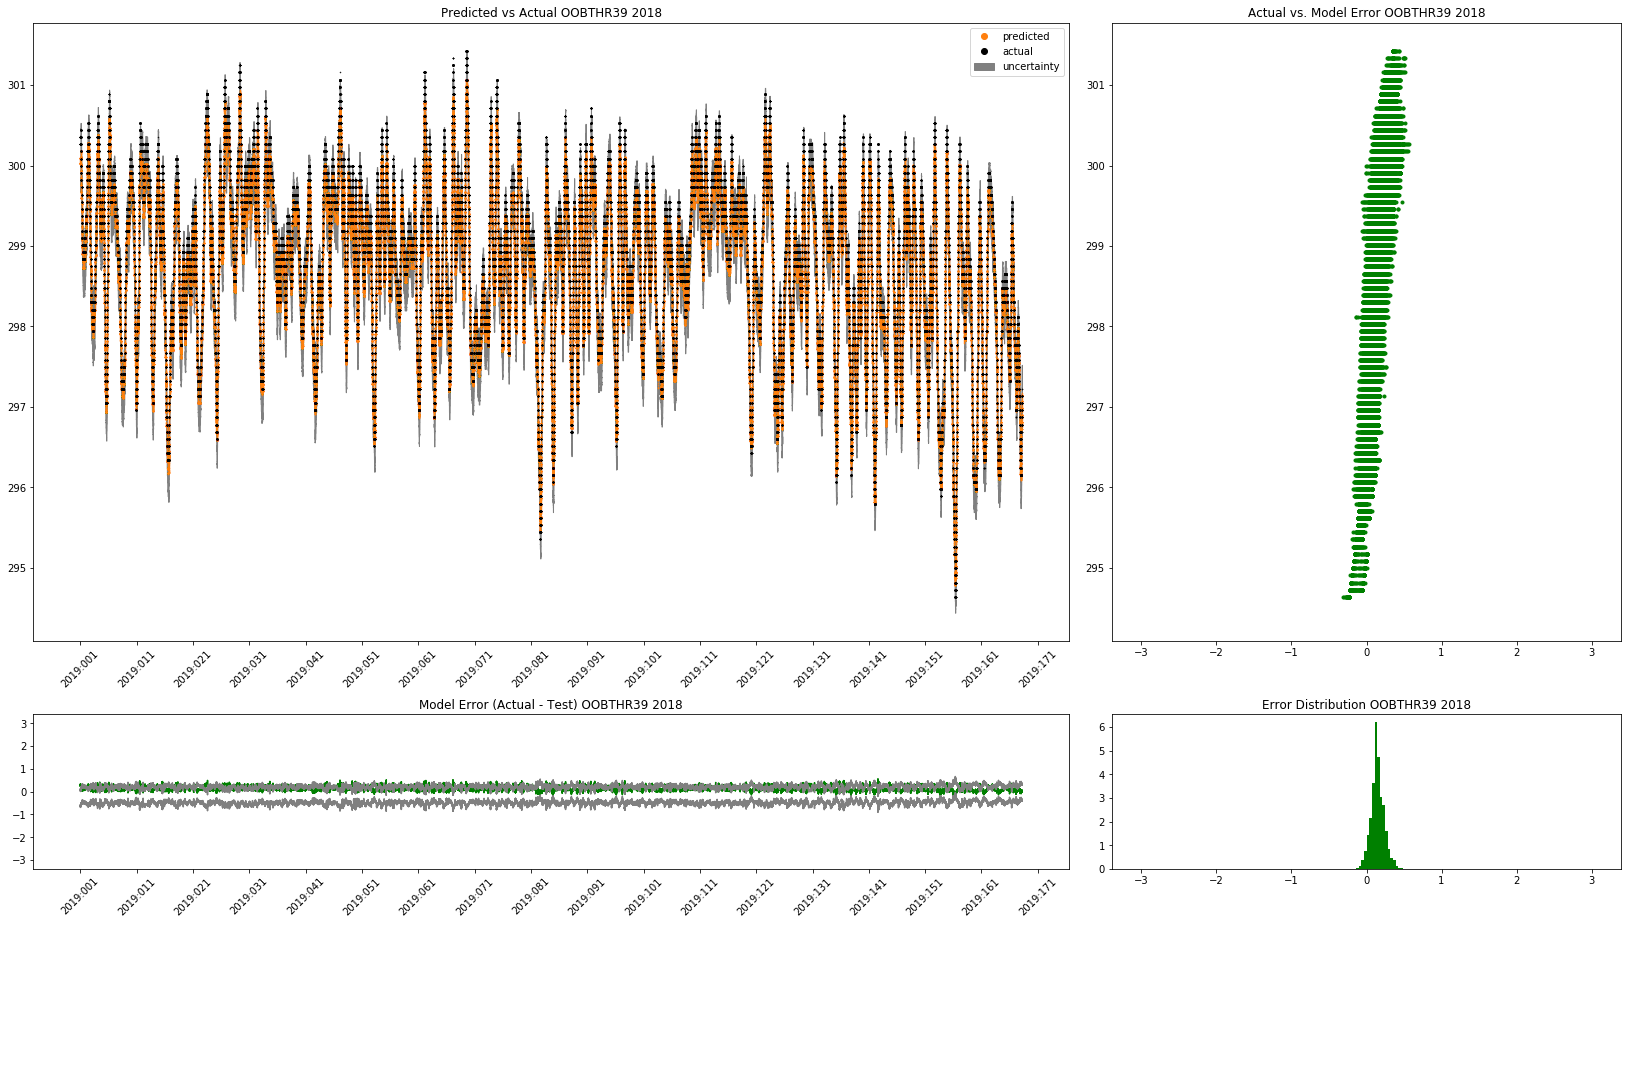

In [10]:
####### STEP 4-8 is for each year individually
####### FETCH AND ORGANIZE DATA ########
%matplotlib inline
import matplotlib.pyplot as plt
from Ska.Matplotlib import plot_cxctime
import math
from datetime import datetime, timedelta, time

import itertools 
import timeit
test_year = 2019
msid_mult_dict = {}

for train_year in train_years:
    test_msid_file = file_format.format(msid_value, test_year)
    train_msid_file = file_format.format(msid_value, train_year)

    train_dict = pd.read_pickle(train_msid_file)
    test_dict = pd.read_pickle(test_msid_file)
    print (train_dict.keys(), test_dict.keys())


    #here we plot our graph and take out any obvious outliers 
    fig, axs = plt.subplots(1, 1)
    train_set = pd.DataFrame(train_dict)
    #msid_set = pd.DataFrame({'times': data[msid_value].times, 'vals': data[msid_value].vals})
    axs.plot(train_set.msid_times, train_set.msid_vals, '.')
    plt.show()
    lower_limit = input("Enter a lower limit if needed:")
    upper_limit = input("Enter an upper limit if needed:")
    if (lower_limit.isdigit()):
        lower_limit = int(lower_limit)
        train_set = train_set[(train_set['msid_vals']>lower_limit)]
    if (upper_limit.isdigit()):
        upper_limit = int(upper_limit)
        train_set = train_set[(train_set['msid_vals']<upper_limit)]
    print (train_set.shape)
    #train_set = train_set[(train_set['msid_vals']>285)]

    fig, axs = plt.subplots(1, 1)
    test_set = pd.DataFrame(test_dict)
    #msid_set = pd.DataFrame({'times': data[msid_value].times, 'vals': data[msid_value].vals})
    axs.plot(test_set.msid_times, test_set.msid_vals, '.')
    plt.show()
    #ACTION ITEM: if this is the first time pulling data for a specific MSID 
    #then uncomment the following line along with the "save" otherwise read_pickle
    cols = ['msid_times', 'msid_vals', 'pitch', 'roll','raw_times']
    pos = ['pitch', 'roll']
    n_features = 3
    frames = 8

    p_W, p_U, p_dense, weight_decay, batch_size, n_neurons = 0.05, 0.05, 0.05, 1e-6, 512, 8
    model, data_to_return, prediction_data, scaler_all, scaler_msid, full_time, avg_time, history, checkpoint_path, modeltest = run_model(train_set, test_set, use_full = False, spacing_int=30,
                  cols=cols, pos=pos, n_features=n_features,
                  frames=frames, train_year=train_year,epochs=150, dropout_B=100, percentage=0.2,
                  p_W=p_W, p_U=p_U, weight_decay=weight_decay, p_dense=p_dense,
                  batch_size=batch_size, n_neurons=n_neurons)
    # this plot gives us info on how our model is doing and whether it's being under/over fit
    fig_hist, ax_hist = plt.subplots()
    ax_hist.plot(history.history['loss'], label = 'train')
    ax_hist.plot(history.history['val_loss'], label = 'validation')
    ax_hist.set_title('loss {}'.format(train_year))
    ax_hist.set_xlabel('epochs')
    ax_hist.set_ylabel('loss over epochs')
    ax_hist.legend()
    plt.show()
    
    predictions, total_uncertainty, uncertainty = prediction_data[0], prediction_data[1], prediction_data[2]
    train, validate, test = data_to_return[0], data_to_return[1], data_to_return[2]
    print (train.shape, validate.shape, test.shape)
    #print (test_time.shape)
    #print (train_X_full)
    train_time_full, val_time_full, test_time = full_time[0], full_time[1], full_time[2]
    train_time_avg, val_time_avg = avg_time[0], avg_time[1]
    print (train_time_full.shape, val_time_full.shape, test_time.shape)

    fig, axs = plt.subplots(1, 1)

    #msid_set = pd.DataFrame({'times': data[msid_value].times, 'vals': data[msid_value].vals})

    axs.plot(train_time_full, train[:,0], val_time_full,validate[:,0], test_time,predictions)

    y_preds = np.squeeze(predictions)
    uncertainty = np.squeeze(uncertainty)
    y_actual = test[:,0]

    from sklearn.metrics import mean_squared_error
    rmse = np.sqrt(mean_squared_error(y_actual, y_preds))
    print('Test RMSE {}: {}'.format(train_year, rmse))
    name_for_dict = '{}'.format(train_year)
    msid_mult_dict[name_for_dict] = {'test_time':test_time, 'y_preds':y_preds, 'y_actual':y_actual, 'uncertainty':uncertainty}
    plot_dashboard(test_time, y_preds, y_actual, uncertainty, test_year, train_year, msid_value)

/home/lduque/miniconda3/envs/ska3/lib/python3.6/site-packages/ipykernel/__main__.py:74: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/lduque/miniconda3/envs/ska3/lib/python3.6/site-packages/IPython/core/pylabtools.py:121: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


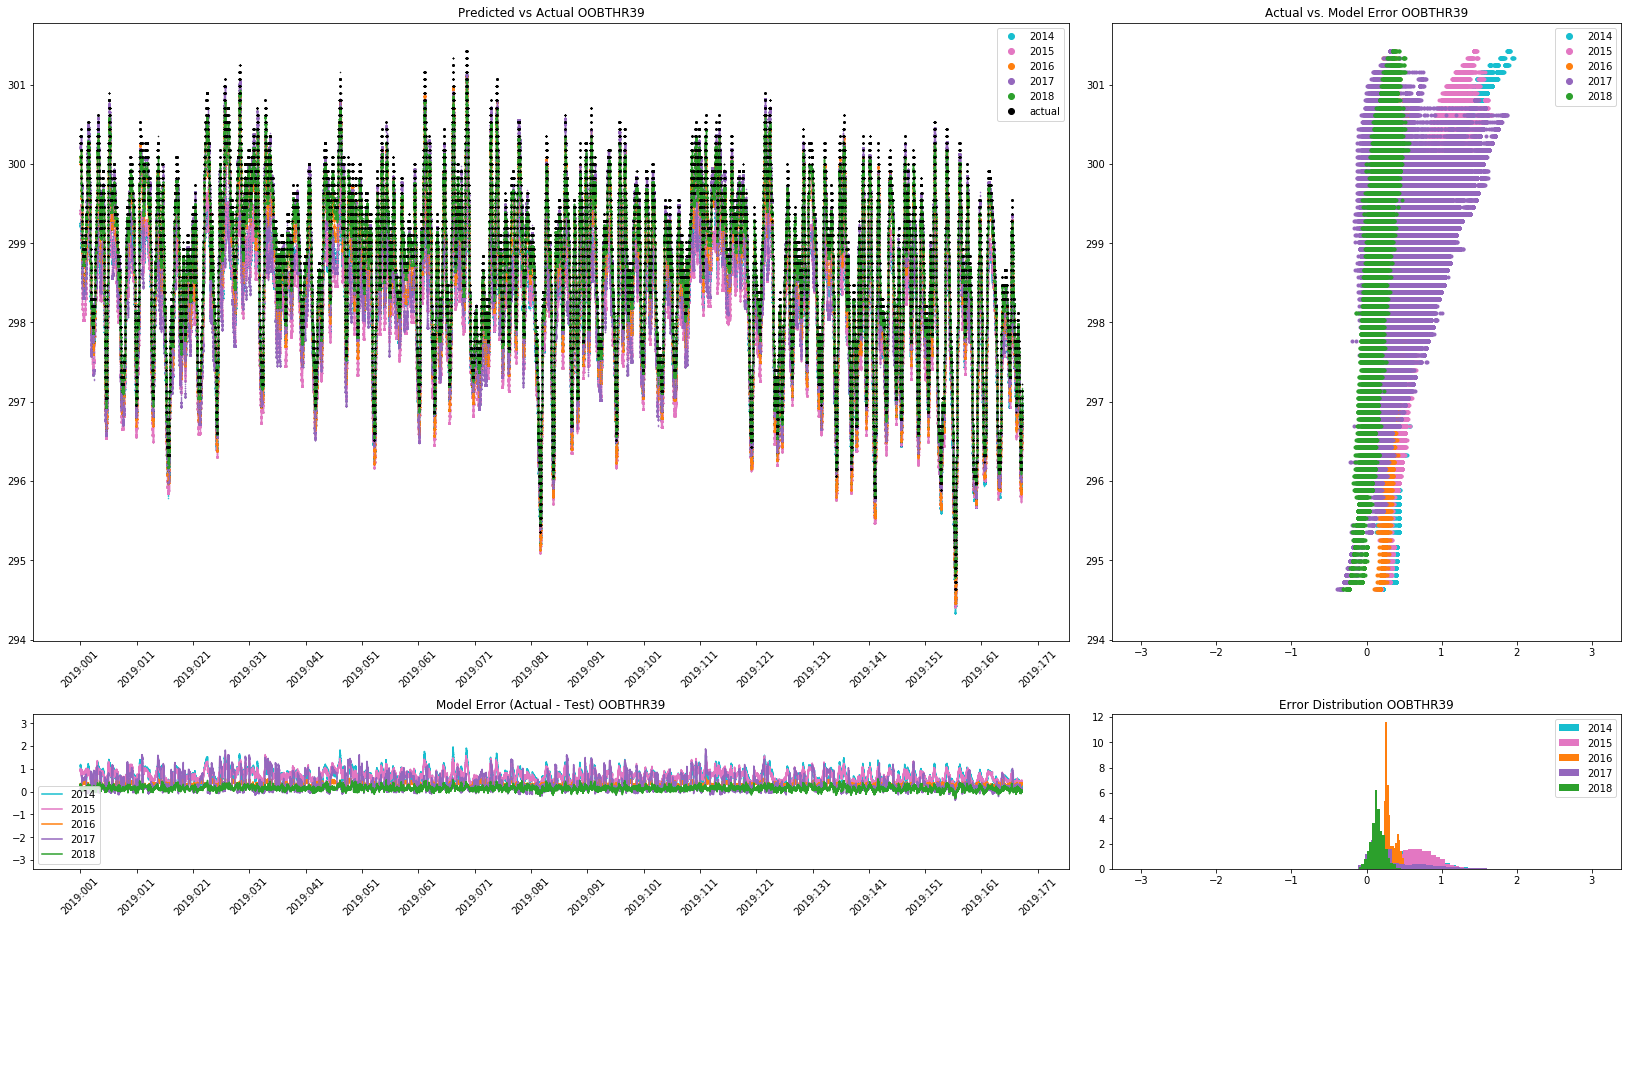

In [11]:
msid_mult_dict.keys()
colors = ['tab:cyan', 'tab:pink', 'tab:orange', 'tab:purple', 'tab:green']
scale_all = 0

fig = plt.figure(figsize=(22.5, 15), constrained_layout=True)
gs = fig.add_gridspec(6,3)

ax1 = fig.add_subplot(gs[0:4,:-1])
ax2 = fig.add_subplot(gs[4,:-1])
ax3 = fig.add_subplot(gs[0:4,2])
ax4 = fig.add_subplot(gs[4, 2])

for i, (k, data) in enumerate(msid_mult_dict.items()):
    year = k
    plot_time, y_preds, y_actual, uncertainty = data['test_time'], data['y_preds'], data['y_actual'], data['uncertainty']
    #err_top, err_bot = y_preds-uncertainty , y_preds+uncertainty
    color = colors[i]

    ##########################
    # Plotting Predicted vs Actual
    # x axis is time, y axis is msid
    ##########################
    ax1.plot(plot_time, y_preds, '.' , markersize = 1, label = year, color = color)

    if i == len(train_years)-1:
        ax1.plot(plot_time, y_actual, '.', markersize = 1, label = 'actual', color = 'black')


    #########################
    # Plotting Model Error which is just actual y value minus test y value
    # x axis is time, y axis is error 
    #########################
    errors =  y_actual - y_preds
    #one_perc = np.quantile(errors, 0.01)
    #nn_perc = np.quantile(errors, .99)
    scale = np.ptp(y_actual)/2.0
    
    ax2.plot(plot_time, errors, color = color, label = year)

    #########################
    # Plotting Error by msid
    # 
    #########################
    ax3.plot(errors, y_actual, '.', color = color, label= year)
    if scale > scale_all:
        ax2.set_ylim(-scale, scale)
        ax3.set_xlim(-scale, scale)
        scale_all = scale

    #histogram of errors by msid
    ax4.hist(errors, bins = 25, density=True, color= color, label=year)

ax1.legend(markerscale=12.0)
ax1.set_xticklabels(plot_time, rotation=45)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y:%j"))
ax1.set_title('Predicted vs Actual {}'.format(msid_value))

ax2.legend(markerscale=12.0)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticklabels(plot_time, rotation=45)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y:%j"))
ax2.set_title('Model Error (Actual - Test) {}'.format(msid_value))

ax3.legend(markerscale=2.0)
ax3.set_ylim(ax1.get_ylim())
ax3.set_title('Actual vs. Model Error {}'.format(msid_value))

ax4.legend(markerscale=12.0)
ax4.set_xlim(ax3.get_xlim())
ax4.set_title("Error Distribution {}".format(msid_value))

plt.savefig('{}_multi_year_dash.png'.format(msid_value))
plt.show()

In [ ]:
#ONLY RUN THIS TO GET MORE INFO/CONSTANT PITCH TIMES
'''#here we will find the observations/time periods to use for training
#this code will most likely be used for the eq database as well
#Find observations since 2018 that have lasted 8 hours or more
dwells = events.dwells.filter(dur__gt=28800, start = '2018:001')
poss_obs = {}

# of these observations pick the ones with constant pitch
# Jean helped with best way to get constant pitch observations
for d in dwells:
    obsid = d.get_obsid()
    pitch = fetch.Msid('DP_PITCH', d.start, d.stop, stat='5min')
    poss_obs[obsid] = (np.mean(pitch.vals), d.stop, d.start)

# organizing the obs data into a useful format
obs_data = {}
for obs_id in poss_obs:
    obs = poss_obs[obs_id]
    t_form = '%Y:%j:%H:%M:%S.%f'
    start, end = datetime.strptime(obs[2], t_form), datetime.strptime(obs[1], t_form)
    dur = end-start
    obs_data[obs_id] = {'pitch': obs[0], 'start': start, 'stop': end, 'dur': dur}

df_obs = pd.DataFrame.from_dict(obs_data, orient = 'index')
# ordered = df_obs.sort_values('dur', ascending = False)'''
#df_obs.to_pickle('constant_pitch_obs.pkl')
#df_obs = pd.read_pickle('constant_pitch_obs.pkl').sort_values('dur', ascending = False)